<a href="https://colab.research.google.com/github/ia35/deeplearning4coders/blob/master/dl_tuto_1_lesson1_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tuto 1 - What's your pet

Cette leçon reprend le cours [fastai](https://course.fast.ai/videos/?lesson=1) de @jeremyphoward : What's your pet

Ce cours a déjà été commenté par nous [ici](http://intelligence-artificielle.agency/notes-sur-la-lecon-1-de-fastai-deep-learning/).  Il s'agit d'aller plus loin dans l'exégèse ! sans reprendre ce qui a déjà été [fait](http://intelligence-artificielle.agency/notes-sur-la-lecon-1-de-fastai-deep-learning/).

Cette leçon vous apprendra à reconnaitre automatiquement, à partir d'une photo, la race de votre chat ou chien

Comme vous le savez (voir leçons précédentes, les notebooks commencent toujours avec les lignes suivantes (dans les cours de fastai) :

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

fastai supporte 4 domaines d'application du Deep Learning :  

1.   vision
2.   text
3.   tabular
4.   collab  (collaborative filtering) 

Lorsqu'on importe fastai on importe en même temps les modules PyTorch

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

Cette remarque ne s'applique pas dans le cas de Google Colab.

*If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again. *

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Données

Le jeu de données est  [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) atrribué à  [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)

Ce jeu comprend des images de chats (12 races) et de chiens (25 races). 
L'exercice consisite à catégoriser correctement une image.

Il y a donc en tout 37 catégories et chaque classe a environ 200 images. Les images sont très variées.

En 2012, le meilleurs score était de 59.21%, avec un logiciel dédié aux chats/chiens.

Ces données sont aussi sur [Kaggle](https://www.kaggle.com/c/oxford-iiit-pet-dataset/overview). 

La métrique recommandée est Multi Class Loss


Lorsqu'on importe fastai, on peut uitliser URLs : Global constants for dataset and model URLs

In [0]:
??URLs

On utilise la fonction untar_data à qui on passe en paramètre une URL. Cette fonction télécharge les données et les décompresse

In [0]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



Notez que `untar_data` retourne un objet de type [pathlib](https://docs.python.org/3/library/pathlib.html) 

In [0]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
type(path)

pathlib.PosixPath

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

Python 3 permet de faire de la concaténation de path de la manière suivante : 

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
path_anno.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/xmls'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/README'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/list.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/test.txt')]

In [0]:
import os
dirs = os.listdir( path_img )

Pour voir la liste des 10 premiers fichiers

(on peut aussi utiliser la fonction fastai get_image_files)

In [0]:
dirs[0:10]

['american_bulldog_20.jpg',
 'Russian_Blue_185.jpg',
 'Persian_8.jpg',
 'great_pyrenees_125.jpg',
 'chihuahua_99.jpg',
 'yorkshire_terrier_144.jpg',
 'pug_91.jpg',
 'keeshond_5.jpg',
 'Bengal_168.jpg',
 'samoyed_175.jpg']

Les étiquettes (labels) des images sont déduites des noms des fichiers.

Par exemple, boxer_46.jpg est un boxer.

Les noms des fichiers sont ici sous la forme d'expressions régulières : race_nombre.ext

fastai a un outil pour ça : `ImageDataBunch.from_name_re` retourne les labels extraits des noms de fichiers à l'aide d'une [expression régulière](https://docs.python.org/3.6/library/re.htm)

In [0]:
??get_image_files

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_20.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_185.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_8.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_125.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_99.jpg')]

In [0]:
np.random.seed(2)

In [0]:
pat = r'/([^/]+)_\d+.jpg$'

Une petite explication de l'expression régulière s'impose, elle veut dire une expression qui commence par un / suivi de tout sauf un slash, suivi de _ puis d'un nombre et de .jpg qui termine l'expression

en plaçant un r' avant le délimiteur qui ouvre notre chaîne, tous les caractères anti-slash qu'elle contient sont échappés

on commence par un /

() crée un groupe, tout sauf un slash [^/] ce qui revient à rechercher le dernier slash /

et pour la fin : _\d+.jpg$

le caractère _ suivi de  \d : chiffre, + : un ou plus donc  \d+ : un ou plusieurs chiffres
 .jpg : suivi de .jpg
 $ : qui termine la ligne

Une autre façon d'écrire l'expression, peut-être plus simple : /[a-z_]*_\d+.jpg$ à condition que seuls ces caractères soient autorisés

Pour ceux qui veulent s'amuser avec les expressions régulières, c'est [ici](https://pythex.org).

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [0]:
??get_transforms

In [0]:
bs

64

ImageDataBunch.from_name_re : Create from list of `fnames` in `path` with re expression `pat`

get_transform : Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms (on fait du cropping, resizing, ...)

Les images sont retaillées pour être carrées en 224

bs est le batch size

Les images sont aussi normalisées pour avoir la moyenne et l'écart-type de imagenet

In [0]:
??ImageDataBunch.from_name_re

In [0]:
??data.show_batch

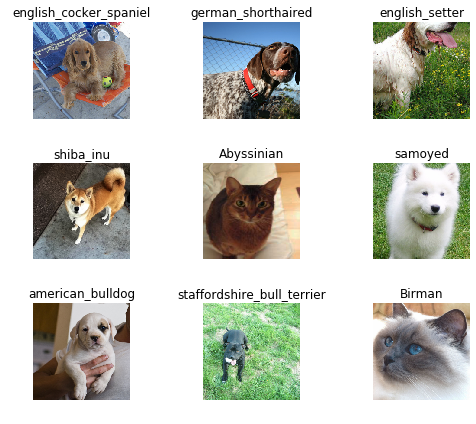

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

On retrouve bien nos 37 classes  : 12 races de chat et 25 de chiens

Pour calculer l'effectuer de chaque classe dans les données d'apprentissage : 

(méthode proposée [ici](https://forums.fast.ai/t/get-value-counts-from-a-imagedatabunch/38784))

In [0]:
import pandas as pd
vc = pd.value_counts(data.train_ds.y.items, sort=False)
vc.index = data.classes; vc

Abyssinian                    167
Bengal                        158
Birman                        152
Bombay                        154
British_Shorthair             163
Egyptian_Mau                  157
Maine_Coon                    148
Persian                       160
Ragdoll                       156
Russian_Blue                  157
Siamese                       163
Sphynx                        160
american_bulldog              172
american_pit_bull_terrier     166
basset_hound                  160
beagle                        159
boxer                         160
chihuahua                     153
english_cocker_spaniel        155
english_setter                158
german_shorthaired            163
great_pyrenees                166
havanese                      153
japanese_chin                 158
keeshond                      154
leonberger                    161
miniature_pinscher            153
newfoundland                  156
pomeranian                    162
pug           

et pour les données de validation

In [0]:
vd = pd.value_counts(data.valid_ds.y.items, sort=False)
vd.index = data.classes; vd

Abyssinian                    33
Bengal                        37
Birman                        42
Bombay                        38
British_Shorthair             42
Egyptian_Mau                  40
Maine_Coon                    37
Persian                       35
Ragdoll                       48
Russian_Blue                  28
Siamese                       34
Sphynx                        35
american_bulldog              46
american_pit_bull_terrier     34
basset_hound                  47
beagle                        46
boxer                         37
chihuahua                     40
english_cocker_spaniel        42
english_setter                29
german_shorthaired            43
great_pyrenees                41
havanese                      46
japanese_chin                 33
keeshond                      52
leonberger                    40
miniature_pinscher            39
newfoundland                  34
pomeranian                    40
pug                           47
saint_bern

## Apprentissage: resnet34

On utilise un [réseau de neurones à convolution](http://cs231n.github.io/convolutional-networks/) basé sur une architecture Resnet

L'apprentissage se fait avec 4 epochs (4 cycles sur la totalité des données)

In [0]:
??error_rate

error_rate = 1 - `accuracy`

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 87915251.08it/s]


Les poids du modèle ResNet34 sont chargés

[PyTorch](https://pytorch.org/docs/stable/torchvision/models.html) propose plusieurs architectures ResNet (18, 34, 50, 101, 152) en plus d'autres architectures (AlexNet, VGG, SqueezeNet, DenseNet, Inception, GoogLeNet)

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.349239,0.331696,0.098782,41:22
1,0.549400,0.230268,0.069689,41:09
2,0.354912,0.214976,0.075778,41:20
3,0.251714,0.210256,0.069012,41:19


In [0]:
learn.save('stage-1')

## Résultats

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

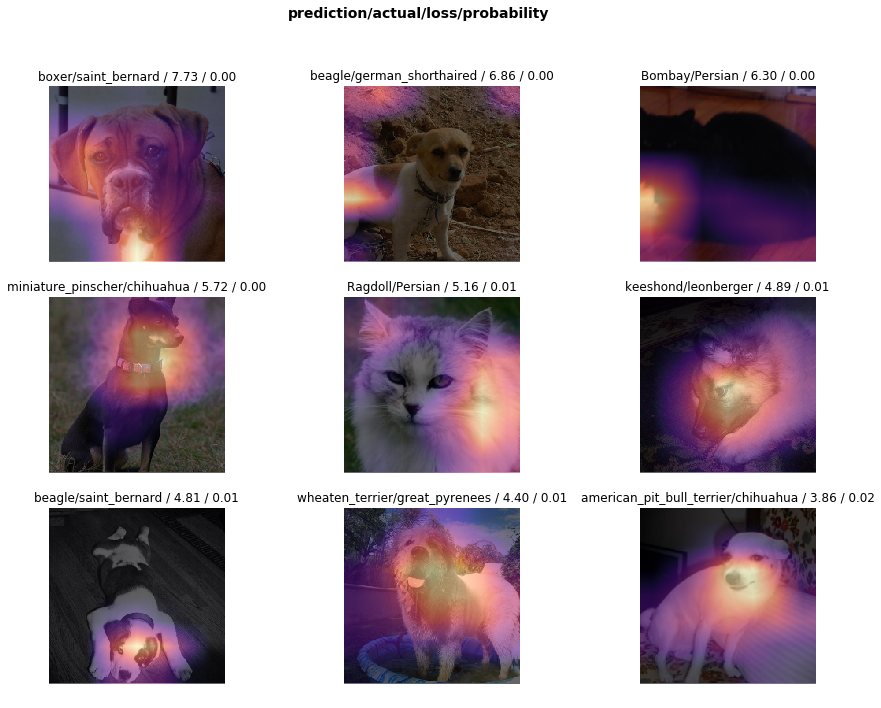

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

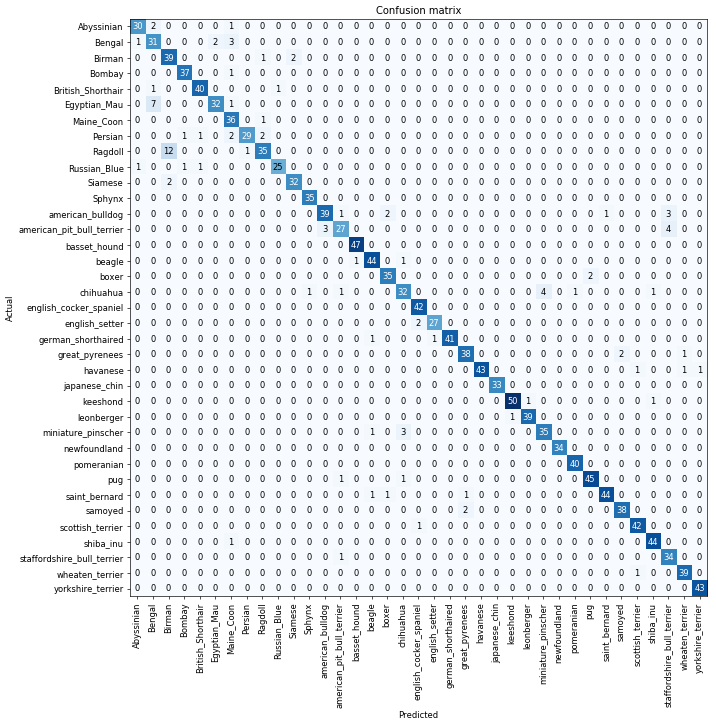

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 12),
 ('Egyptian_Mau', 'Bengal', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('Bengal', 'Maine_Coon', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Abyssinian', 'Bengal', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Birman', 'Siamese', 2),
 ('Persian', 'Maine_Coon', 2),
 ('Persian', 'Ragdoll', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'boxer', 2),
 ('boxer', 'pug', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('great_pyrenees', 'samoyed', 2),
 ('samoyed', 'great_pyrenees', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.513195,0.326874,0.105548,57:29


In [0]:
learn.load('stage-1');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


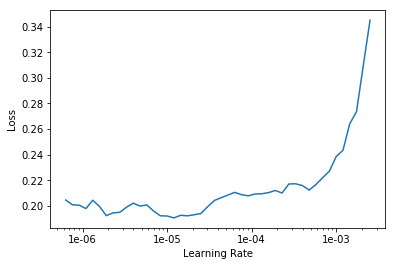

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.226497,0.199981,0.063599,55:59
1,0.213618,0.196294,0.064276,55:52


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


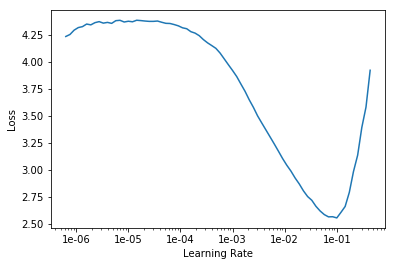

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

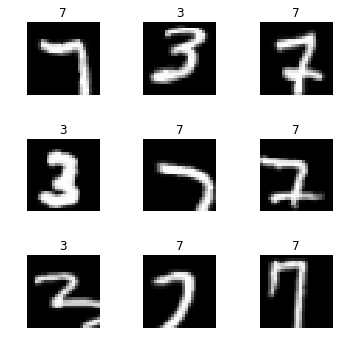

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

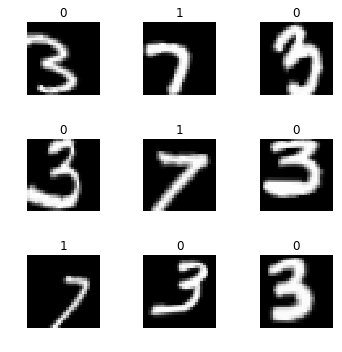

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']